Learning to Learn - John Tomlinson, Ahan Maurya, Dr. Jing Wang

First we need to import the modules we created for this notebook

In [5]:
import meta_network
import original_network
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Reload to pick up on-disk changes to original_network
import importlib
importlib.reload(original_network)

<module 'original_network' from 'c:\\Users\\bobtt\\OneDrive\\Desktop\\Documents\\JackCS\\learning-to-learn\\cartpole-implementation\\original_network.py'>

We will start by initializing both of our networks

In [19]:
cartpole_network, cartpole_target_network,memory, optimizer, device, env = original_network.build_model()
meta_network, meta_memory = meta_network.build_model(1,1)

Now lets build a function to graph our reward over time

In [10]:
def plot_rewards(reward_list):
    plt.plot(reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward over Time')
    plt.show()

Lets make a training loop to get our baseline performance for our model wihtout the meta learning

In [23]:
NUM_EPISODES = 300
TARGET_UPDATE = 10

In [24]:
def training_loop(episodes):
    total_reward_list = []
    epsilon = 0.1  # Exploration rate
    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = original_network.select_action(state, cartpole_network, device, epsilon, env)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            original_network.optimize_model(cartpole_network, cartpole_target_network, memory, optimizer, device)

        if episode % TARGET_UPDATE == 0:
            cartpole_target_network.load_state_dict(cartpole_network.state_dict())

        print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
        total_reward_list.append(total_reward)
    return total_reward_list

Episode 1/300, Total Reward: 183.0
Episode 2/300, Total Reward: 263.0
Episode 2/300, Total Reward: 263.0
Episode 3/300, Total Reward: 296.0
Episode 3/300, Total Reward: 296.0
Episode 4/300, Total Reward: 192.0
Episode 4/300, Total Reward: 192.0
Episode 5/300, Total Reward: 257.0
Episode 5/300, Total Reward: 257.0
Episode 6/300, Total Reward: 260.0
Episode 6/300, Total Reward: 260.0
Episode 7/300, Total Reward: 213.0
Episode 7/300, Total Reward: 213.0
Episode 8/300, Total Reward: 179.0
Episode 8/300, Total Reward: 179.0
Episode 9/300, Total Reward: 217.0
Episode 9/300, Total Reward: 217.0
Episode 10/300, Total Reward: 222.0
Episode 10/300, Total Reward: 222.0
Episode 11/300, Total Reward: 223.0
Episode 11/300, Total Reward: 223.0
Episode 12/300, Total Reward: 203.0
Episode 12/300, Total Reward: 203.0
Episode 13/300, Total Reward: 248.0
Episode 13/300, Total Reward: 248.0
Episode 14/300, Total Reward: 206.0
Episode 14/300, Total Reward: 206.0
Episode 15/300, Total Reward: 178.0
Episode 1

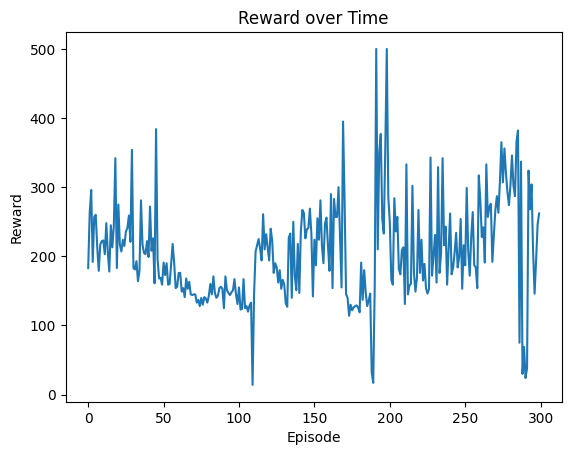

In [25]:
plot_rewards(training_loop(NUM_EPISODES))